In [10]:
!python demo.py --Enet_ckpt models/G_w_checkpoint_13820.pt --Tnet_ckpt models/L_w_checkpoint_27640.pt --img_path x.jpg --out_dir output/

models/G_w_checkpoint_13820.pt
img_path: x.jpg


c:\Users\luong\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
!pwd

/d/PPYCode/PaperEdge


# Code

## import

In [1]:
import argparse
import copy
import json
from pathlib import Path

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from networks.paperedge import GlobalWarper, LocalWarper, WarperUtil

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

In [2]:
def load_img(img_path):
    im = cv2.imread(img_path).astype(np.float32) / 255.0
    im = im[:, :, (2, 1, 0)]
    im = cv2.resize(im, (256, 256), interpolation=cv2.INTER_AREA)
    im = torch.from_numpy(np.transpose(im, (2, 0, 1)))
    return im

In [4]:
Enet_ckpt = 'models/G_w_checkpoint_13820.pt'
Tnet_ckpt = 'models/L_w_checkpoint_27640.pt'

netG = GlobalWarper().to('cuda')
netG.load_state_dict(torch.load(Enet_ckpt)['G'])
netG.eval()

netL = LocalWarper().to('cuda')
netL.load_state_dict(torch.load(Tnet_ckpt)['L'])
netL.eval()

LocalWarper(
  (encoder): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (actv): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(128, 256, kernel_si

In [5]:
warpUtil = WarperUtil(64).to('cuda')

In [6]:
def infer(netG, netL, img_path):
    gs_d, ls_d = None, None
    with torch.no_grad():
        x = load_img(img_path)
        x = x.unsqueeze(0)
        x = x.to('cuda')
        d = netG(x)  # d_E the edged-based deformation field
        d = warpUtil.global_post_warp(d, 64)
        gs_d = copy.deepcopy(d)

        d = F.interpolate(d, size=256, mode='bilinear', align_corners=True)
        y0 = F.grid_sample(x, d.permute(0, 2, 3, 1), align_corners=True)
        ls_d = netL(y0)
        ls_d = F.interpolate(ls_d, size=256, mode='bilinear', align_corners=True)
        ls_d = ls_d.clamp(-1.0, 1.0)

    im = cv2.imread(img_path).astype(np.float32) / 255.0
    im = torch.from_numpy(np.transpose(im, (2, 0, 1)))
    im = im.to('cuda').unsqueeze(0)

    gs_d = F.interpolate(gs_d, (im.size(2), im.size(3)), mode='bilinear', align_corners=True)
    gs_y = F.grid_sample(im, gs_d.permute(0, 2, 3, 1), align_corners=True).detach()
    tmp_y = gs_y.squeeze().permute(1, 2, 0).cpu().numpy()
    # cv2.imwrite(f'{dst_dir}/result_gs.png', tmp_y * 255.)

    ls_d = F.interpolate(ls_d, (im.size(2), im.size(3)), mode='bilinear', align_corners=True)
    ls_y = F.grid_sample(gs_y, ls_d.permute(0, 2, 3, 1), align_corners=True).detach()
    ls_y = ls_y.squeeze().permute(1, 2, 0).cpu().numpy()

    return tmp_y * 255., ls_y * 255.
    # cv2.imwrite(f'{dst_dir}/result_ls.png', ls_y * 255.)

In [8]:
from IPython import display
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm_notebook
for each_path in tqdm_notebook(glob.glob(r'D:\PPYData\image_rotate_dataset\image/*.*')):
    base_name = os.path.basename(each_path)
    result_gs, result_ls = infer(netG, netL, each_path)
    pil_result_ls = Image.fromarray(result_ls.astype(np.uint8))
    cv2.imwrite(f'img_out/result_ls_{base_name}', result_ls)
    break
    # display.display(pil_result_ls)
# result_gs, result_ls = infer(netG, netL, 'images/947.jpeg')
# pil_result_ls = Image.fromarray(result_ls.astype(np.uint8))
# plt.imshow(pil_result_ls)
# cv2.imwrite('result_ls.png', result_ls)
# # display.display(pil_result_ls)

C:\Users\luong\AppData\Local\Temp\ipykernel_3536\1240254679.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for each_path in tqdm_notebook(glob.glob(r'D:\PPYData\image_rotate_dataset\image/*.*')):


  0%|          | 0/2471 [00:00<?, ?it/s]

In [56]:
# result_ls.astype(int).shape

(3000, 2248, 3)

In [57]:
# result_ls = result_ls.astype(np.int32)

In [66]:
x = cv2.imread('result_ls.png')

In [68]:
y = Image.fromarray(x)

In [76]:
test = result_ls.astype(np.uint8)
test_y = Image.fromarray(test)
display.display(test_y)

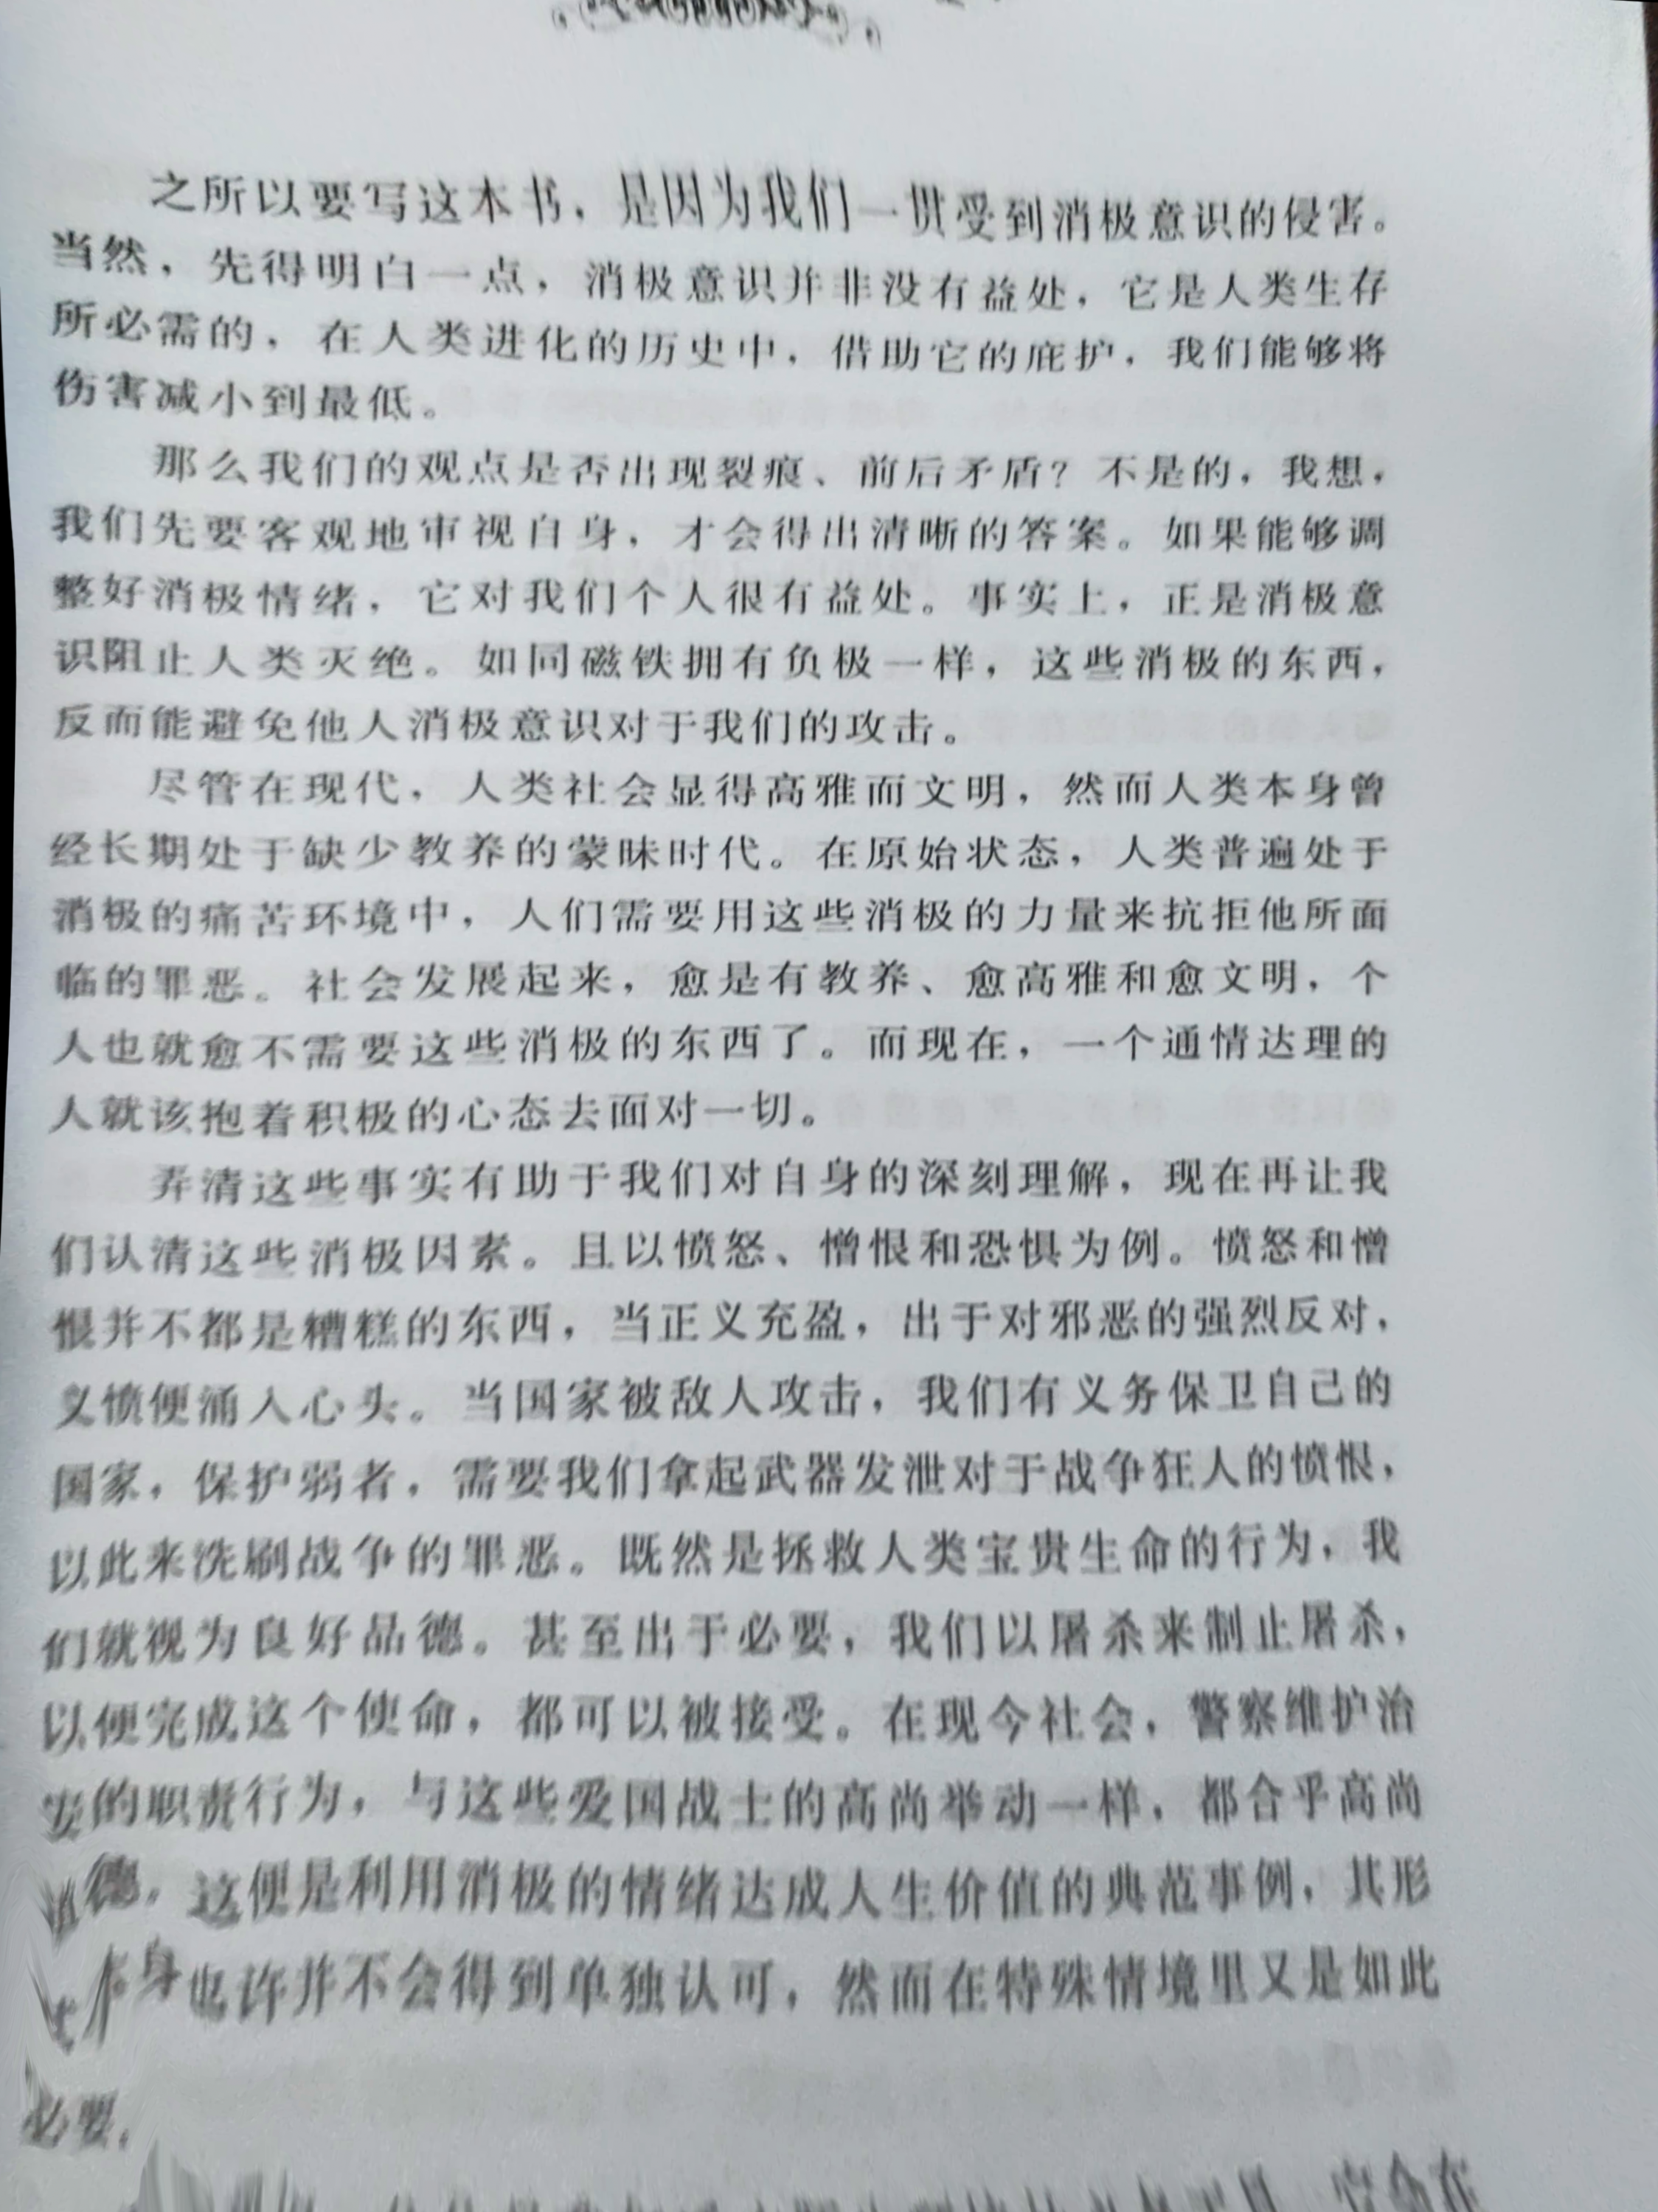